In [109]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker


In [54]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# training = pd.read_csv('Data/ab_wind_train_data.txt')
# testing = pd.read_csv('Data/ab_wind_test_data.txt')
# All data without null, 2.5m
data = pd.read_csv('Data\processed_ab_wind.csv')

C:\Users\PPL\AppData\Local\Temp\ipykernel_60320\1868364170.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data\processed_ab_wind.csv')


In [12]:
grouped_by_datge_data = data.groupby('date')

In [13]:
np.bincount(grouped_by_datge_data.size()).argmax() #32 stations is the max number of stations for most dates

32

In [15]:
size = grouped_by_datge_data.size()

In [29]:
dates_with_most_stations = size.index[size == 32]

In [30]:
dates_with_most_stations

Index(['2014-05-28 17:00', '2014-06-04 12:00', '2014-06-04 20:00',
       '2014-06-04 21:00', '2014-06-04 22:00', '2014-06-05 00:00',
       '2014-06-05 10:00', '2014-06-07 16:00', '2014-06-09 12:00',
       '2014-06-20 10:00',
       ...
       '2023-09-12 23:00', '2023-09-13 00:00', '2023-09-13 03:00',
       '2023-09-13 04:00', '2023-09-13 21:00', '2023-09-14 02:00',
       '2023-09-14 06:00', '2023-09-14 08:00', '2023-09-14 15:00',
       '2023-09-14 16:00'],
      dtype='object', name='date', length=14428)

In [31]:
filtered_data = data.loc[data['date'].isin(dates_with_most_stations)]

In [104]:
filtered_data['name'].unique().shape

(38,)

Text(0.5, 0, 'Number of stations')

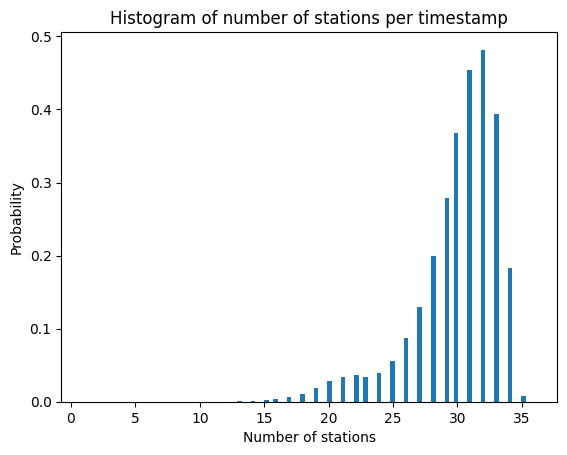

In [33]:
plt.hist(size, bins=100, density=True)
plt.title("Histogram of number of stations per timestamp")
plt.ylabel("Probability")
plt.xlabel("Number of stations")

In [35]:
filtered_data['name'].unique()

array(['CAMROSE', 'CORONATION CLIMATE', 'EDMONTON INTERNATIONAL CS',
       'EDMONTON BLATCHFORD', 'LLOYDMINSTER', 'ROCKY MTN HOUSE (AUT)',
       'VEGREVILLE', 'EDMONTON STONY PLAIN CS', 'DRUMHELLER EAST',
       'LACOMBE CDA 2', 'RED DEER REGIONAL A', 'SUNDRE A', 'BROOKS',
       "CALGARY INT'L CS", 'CLARESHOLM', 'LETHBRIDGE', 'LETHBRIDGE CDA',
       'MEDICINE HAT', 'MEDICINE HAT RCS', 'PINCHER CREEK CLIMATE',
       'STRATHMORE AGDM', 'MILK RIVER', 'ONEFOUR CDA', 'BANFF CS',
       'BOW VALLEY', 'JASPER WARDEN', 'WHITECOURT A', 'EDSON',
       'EDSON CLIMATE', 'FORT MCMURRAY CS', 'FORT MCMURRAY A',
       'SLAVE LAKE', 'SLAVE LAKE RCS', 'FORT CHIPEWYAN',
       'FORT CHIPEWYAN RCS', 'HIGH LEVEL A', 'HIGH LEVEL', 'RED EARTH'],
      dtype=object)

In [39]:
filtered_train_dates, filtered_test_dates = train_test_split(dates_with_most_stations, test_size = 0.3)

In [41]:
filtered_train = filtered_data.loc[filtered_data['date'].isin(filtered_train_dates)]
filtered_test = filtered_data.loc[filtered_data['date'].isin(filtered_test_dates)]

In [43]:
filtered_test

,longitude,latitude,name,id,date,temp,precip,wind_direction,wind_speed
3780,-112.82,53.05,CAMROSE,3011240,2014-06-04 12:00,18.0,0.0,7.0,6.0
3788,-112.82,53.05,CAMROSE,3011240,2014-06-04 20:00,8.6,5.7,35.0,28.0
3895,-112.82,53.05,CAMROSE,3011240,2014-06-09 12:00,11.7,0.0,30.0,44.0
4333,-112.82,53.05,CAMROSE,3011240,2014-06-28 16:00,18.7,0.6,30.0,14.0
4818,-112.82,53.05,CAMROSE,3011240,2014-07-19 09:00,17.2,0.0,31.0,21.0
...,...,...,...,...,...,...,...,...,...
2560148,-115.28,56.55,RED EARTH,3075488,2023-07-18 16:00,21.8,0.0,21.0,5.0
2560163,-115.28,56.55,RED EARTH,3075488,2023-07-19 07:00,15.2,0.0,19.0,6.0
2560169,-115.28,56.55,RED EARTH,3075488,2023-07-19 13:00,22.1,0.0,25.0,7.0
2560187,-115.28,56.55,RED EARTH,3075488,2023-07-20 07:00,12.8,0.2,16.0,5.0


In [62]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [65]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    # Fcm hyperparameters
    FCM_Nc = 10
    FCM_m = 2
    tol = 1e-5
    max_iter = 100

    
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break

    # 模型训练
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
#     plt.plot(train_y, y_hat_train, 'ro', alpha=.2)
    
# #     plt.scatter(range(len(train_y)), train_y, c='blue', label='Target')
# #     plt.scatter(range(len(y_hat_train)), y_hat_train, c='red', label='Predict')
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
#     plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
# #     plt.scatter(range(len(test_y)), test_y, c='blue', label='Target')
# #     plt.scatter(range(len(y_hat_test)), y_hat_test, c='red', label='Predict')
#     plt.title('Testing')
#     plt.legend()
#     plt.show()
    plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
    plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
    plt.title('FCM prediction vs true value for testing data')
    plt.legend()


    return rmse_train, rmse_validation


In [66]:
def linear_model(train_x, train_y, validation_x, validation_y):
    reg = LinearRegression().fit(train_x, train_y)
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False)

In [67]:
def build_neural_network_model():
    model = models.Sequential()
    
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1))    
    
    return model

In [68]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error'])), neural_network_model

In [59]:
# Filter and process the data suitable for the training/testing
def generate_exp_data(raw_data, number_of_stations, max_threshold_distance, min_threshold_distance):
    # First fitler the data based on the settings
    x = []
    y = []

    for station in raw_data['name'].unique():
        features, target = Data_utils.generate_data(
            raw_data, 
            station, 
            number_of_stations, 
            max_threshold_distance, 
            min_threshold_distance
        )

        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            x.append(np_features)
            y.append(np_target)
    
    return x, y

In [70]:
# hyperparameters for the expeirment
number_of_neighbour_stations = [1,2,3,4,5,6] # 2 is optimal
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 10
# General hyperparameter
max_threshold_distance = 200 #km
min_threshold_distance = 0 #km

# Results containers
training_results = []
validation_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values, training_data, x_container, y_container):
    kf = KFold(n_splits=number_of_folds, shuffle=True)
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # First fitler the data based on the settings
        train_x, train_y = generate_exp_data(training_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
        
        # After all stations are filtered, flatten the data into a huge list        
        flatten_x = np.array([data for sublist in train_x for data in sublist])
        flatten_y = np.array([data for sublist in train_y for data in sublist])
        
        x_container = flatten_x
        y_container = flatten_y
        
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        validation_results_fold = []
        test_results_fold = []
        nn_history_fold = []
        
        for i, (train_index, val_index) in enumerate(kf.split(flatten_x)):
            split_train_x = flatten_x[train_index]
            split_train_y = flatten_y[train_index]

            split_val_x = flatten_x[val_index]
            split_val_y = flatten_y[val_index]
            # Normalize the input
            split_train_x, split_val_x = preprocess_data(split_train_x, split_val_x)            
            # Linear model
            li_train_rmse, li_val_rmse = linear_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            validation_results_fold.append({'linear_val' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            validation_results_fold.append({'fcm_val' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse, _ = neural_network_model(split_train_x, split_train_y, split_val_x , split_val_y)
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            validation_results_fold.append({'nn_val' : nn_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        validation_results.append(validation_results_fold)
        nn_histories.append(nn_history_fold)
        
        

In [73]:
# Containers of data for current iteration
temp_x = None
temp_y= None

target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 1
target FORT CHIPEWYAN RCS has neightbour_stations 0 not match number_of_neighbours 1


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.100558428876212
linear_validation
6.123316293616617
FCM traning RMSE: 6.087692487143892


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.117007095638417
Epoch 1/50
6473/6473 [==============================] - 16s 2ms/step - loss: 50.5572 - root_mean_squared_error: 7.1104 - val_loss: 37.3528 - val_root_mean_squared_error: 6.1117
Epoch 2/50
6473/6473 [==============================] - 16s 2ms/step - loss: 36.1383 - root_mean_squared_error: 6.0115 - val_loss: 35.6732 - val_root_mean_squared_error: 5.9727
Epoch 3/50
6473/6473 [==============================] - 16s 2ms/step - loss: 35.1293 - root_mean_squared_error: 5.9270 - val_loss: 34.7742 - val_root_mean_squared_error: 5.8970
Epoch 4/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.5696 - root_mean_squared_error: 5.8796 - val_loss: 34.5561 - val_root_mean_squared_error: 5.8784
Epoch 5/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.1626 - root_mean_squared_error: 5.8449 - val_loss: 34.5009 - val_root_mean_squared_error: 5.8737
Epoch 6/50
6473/6473 [==============================] - 15s 2ms/step - loss: 33.933

Epoch 47/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.3401 - root_mean_squared_error: 5.6868 - val_loss: 33.0498 - val_root_mean_squared_error: 5.7489
Epoch 48/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.3506 - root_mean_squared_error: 5.6878 - val_loss: 32.7986 - val_root_mean_squared_error: 5.7270
Epoch 49/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.3524 - root_mean_squared_error: 5.6879 - val_loss: 32.8302 - val_root_mean_squared_error: 5.7298
Epoch 50/50
6473/6473 [==============================] - 16s 2ms/step - loss: 32.3016 - root_mean_squared_error: 5.6834 - val_loss: 32.9213 - val_root_mean_squared_error: 5.7377


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.093371278481359
linear_validation
6.189263870579618
FCM traning RMSE: 6.071422494787108


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.16193590631716
Epoch 1/50
6473/6473 [==============================] - 16s 2ms/step - loss: 53.7908 - root_mean_squared_error: 7.3342 - val_loss: 38.2041 - val_root_mean_squared_error: 6.1809
Epoch 2/50
6473/6473 [==============================] - 16s 2ms/step - loss: 36.2036 - root_mean_squared_error: 6.0169 - val_loss: 37.0193 - val_root_mean_squared_error: 6.0843
Epoch 3/50
6473/6473 [==============================] - 16s 2ms/step - loss: 35.1468 - root_mean_squared_error: 5.9285 - val_loss: 36.2222 - val_root_mean_squared_error: 6.0185
Epoch 4/50
6473/6473 [==============================] - 16s 2ms/step - loss: 34.6093 - root_mean_squared_error: 5.8830 - val_loss: 36.0227 - val_root_mean_squared_error: 6.0019
Epoch 5/50
6473/6473 [==============================] - 13s 2ms/step - loss: 34.2607 - root_mean_squared_error: 5.8533 - val_loss: 35.7424 - val_root_mean_squared_error: 5.9785
Epoch 6/50
6473/6473 [==============================] - 13s 2ms/step - loss: 34.0295

Epoch 47/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.4769 - root_mean_squared_error: 5.6988 - val_loss: 34.1555 - val_root_mean_squared_error: 5.8443
Epoch 48/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.4585 - root_mean_squared_error: 5.6972 - val_loss: 34.0464 - val_root_mean_squared_error: 5.8349
Epoch 49/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.4472 - root_mean_squared_error: 5.6962 - val_loss: 33.9264 - val_root_mean_squared_error: 5.8246
Epoch 50/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.4516 - root_mean_squared_error: 5.6966 - val_loss: 33.9275 - val_root_mean_squared_error: 5.8247


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.111156069672127
linear_validation
6.027339794006281
FCM traning RMSE: 6.097701243880404


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.019219630986781
Epoch 1/50
6473/6473 [==============================] - 16s 2ms/step - loss: 49.9169 - root_mean_squared_error: 7.0652 - val_loss: 35.7833 - val_root_mean_squared_error: 5.9819
Epoch 2/50
6473/6473 [==============================] - 15s 2ms/step - loss: 36.1411 - root_mean_squared_error: 6.0117 - val_loss: 34.9885 - val_root_mean_squared_error: 5.9151
Epoch 3/50
6473/6473 [==============================] - 14s 2ms/step - loss: 35.1717 - root_mean_squared_error: 5.9306 - val_loss: 33.9895 - val_root_mean_squared_error: 5.8301
Epoch 4/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.5979 - root_mean_squared_error: 5.8820 - val_loss: 33.8369 - val_root_mean_squared_error: 5.8169
Epoch 5/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.2265 - root_mean_squared_error: 5.8503 - val_loss: 33.6474 - val_root_mean_squared_error: 5.8006
Epoch 6/50
6473/6473 [==============================] - 14s 2ms/step - loss: 33.973

Epoch 47/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.3145 - root_mean_squared_error: 5.6846 - val_loss: 32.2545 - val_root_mean_squared_error: 5.6793
Epoch 48/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.3074 - root_mean_squared_error: 5.6840 - val_loss: 32.3602 - val_root_mean_squared_error: 5.6886
Epoch 49/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.3277 - root_mean_squared_error: 5.6857 - val_loss: 32.3225 - val_root_mean_squared_error: 5.6853
Epoch 50/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.3054 - root_mean_squared_error: 5.6838 - val_loss: 32.1256 - val_root_mean_squared_error: 5.6679


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.0954891586564255
linear_validation
6.17569283241712
FCM traning RMSE: 6.084614113568301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.1519302940855685
Epoch 1/50
6473/6473 [==============================] - 14s 2ms/step - loss: 50.7949 - root_mean_squared_error: 7.1271 - val_loss: 38.3300 - val_root_mean_squared_error: 6.1911
Epoch 2/50
6473/6473 [==============================] - 14s 2ms/step - loss: 36.4278 - root_mean_squared_error: 6.0355 - val_loss: 36.8618 - val_root_mean_squared_error: 6.0714
Epoch 3/50
6473/6473 [==============================] - 15s 2ms/step - loss: 35.3327 - root_mean_squared_error: 5.9441 - val_loss: 36.1827 - val_root_mean_squared_error: 6.0152
Epoch 4/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.7326 - root_mean_squared_error: 5.8934 - val_loss: 37.1862 - val_root_mean_squared_error: 6.0980
Epoch 5/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.3504 - root_mean_squared_error: 5.8609 - val_loss: 34.9651 - val_root_mean_squared_error: 5.9131
Epoch 6/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.08

Epoch 47/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.3027 - root_mean_squared_error: 5.6835 - val_loss: 33.4216 - val_root_mean_squared_error: 5.7811
Epoch 48/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.3120 - root_mean_squared_error: 5.6844 - val_loss: 33.5028 - val_root_mean_squared_error: 5.7882
Epoch 49/50
6473/6473 [==============================] - 13s 2ms/step - loss: 32.2760 - root_mean_squared_error: 5.6812 - val_loss: 33.4789 - val_root_mean_squared_error: 5.7861
Epoch 50/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.3005 - root_mean_squared_error: 5.6834 - val_loss: 33.6290 - val_root_mean_squared_error: 5.7991


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.106846411592183
linear_validation
6.067272065790304
FCM traning RMSE: 6.090368541918226


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.047424070562693
Epoch 1/50
6473/6473 [==============================] - 17s 3ms/step - loss: 52.5734 - root_mean_squared_error: 7.2507 - val_loss: 36.9640 - val_root_mean_squared_error: 6.0798
Epoch 2/50
6473/6473 [==============================] - 16s 2ms/step - loss: 36.4172 - root_mean_squared_error: 6.0347 - val_loss: 35.2084 - val_root_mean_squared_error: 5.9337
Epoch 3/50
6473/6473 [==============================] - 15s 2ms/step - loss: 35.1805 - root_mean_squared_error: 5.9313 - val_loss: 34.3378 - val_root_mean_squared_error: 5.8598
Epoch 4/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.6920 - root_mean_squared_error: 5.8900 - val_loss: 33.8338 - val_root_mean_squared_error: 5.8167
Epoch 5/50
6473/6473 [==============================] - 16s 2ms/step - loss: 34.3828 - root_mean_squared_error: 5.8637 - val_loss: 33.6888 - val_root_mean_squared_error: 5.8042
Epoch 6/50
6473/6473 [==============================] - 16s 3ms/step - loss: 34.145

Epoch 47/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5535 - root_mean_squared_error: 5.7056 - val_loss: 32.5376 - val_root_mean_squared_error: 5.7042
Epoch 48/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5591 - root_mean_squared_error: 5.7061 - val_loss: 32.8621 - val_root_mean_squared_error: 5.7326
Epoch 49/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5334 - root_mean_squared_error: 5.7038 - val_loss: 32.8116 - val_root_mean_squared_error: 5.7281
Epoch 50/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.5278 - root_mean_squared_error: 5.7033 - val_loss: 32.5558 - val_root_mean_squared_error: 5.7058


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.1018177317112645
linear_validation
6.114271651838871
FCM traning RMSE: 6.083687680311279


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.098888958316325
Epoch 1/50
6473/6473 [==============================] - 16s 2ms/step - loss: 54.1175 - root_mean_squared_error: 7.3565 - val_loss: 38.8399 - val_root_mean_squared_error: 6.2322
Epoch 2/50
6473/6473 [==============================] - 15s 2ms/step - loss: 37.0012 - root_mean_squared_error: 6.0829 - val_loss: 36.3278 - val_root_mean_squared_error: 6.0273
Epoch 3/50
6473/6473 [==============================] - 15s 2ms/step - loss: 35.8323 - root_mean_squared_error: 5.9860 - val_loss: 35.4234 - val_root_mean_squared_error: 5.9518
Epoch 4/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.9935 - root_mean_squared_error: 5.9155 - val_loss: 35.0344 - val_root_mean_squared_error: 5.9190
Epoch 5/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.5069 - root_mean_squared_error: 5.8743 - val_loss: 34.6185 - val_root_mean_squared_error: 5.8838
Epoch 6/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.247

Epoch 47/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.5787 - root_mean_squared_error: 5.7078 - val_loss: 33.1780 - val_root_mean_squared_error: 5.7600
Epoch 48/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5312 - root_mean_squared_error: 5.7036 - val_loss: 33.0201 - val_root_mean_squared_error: 5.7463
Epoch 49/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5608 - root_mean_squared_error: 5.7062 - val_loss: 33.0011 - val_root_mean_squared_error: 5.7447
Epoch 50/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.5556 - root_mean_squared_error: 5.7058 - val_loss: 33.1478 - val_root_mean_squared_error: 5.7574


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.112300178740407
linear_validation
6.017170524959453
FCM traning RMSE: 6.093317834938327


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.000819420777663
Epoch 1/50
6473/6473 [==============================] - 15s 2ms/step - loss: 52.0802 - root_mean_squared_error: 7.2167 - val_loss: 36.3420 - val_root_mean_squared_error: 6.0284
Epoch 2/50
6473/6473 [==============================] - 14s 2ms/step - loss: 37.0594 - root_mean_squared_error: 6.0876 - val_loss: 35.4602 - val_root_mean_squared_error: 5.9548
Epoch 3/50
6473/6473 [==============================] - 15s 2ms/step - loss: 35.6189 - root_mean_squared_error: 5.9682 - val_loss: 33.7412 - val_root_mean_squared_error: 5.8087
Epoch 4/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.8853 - root_mean_squared_error: 5.9064 - val_loss: 33.3569 - val_root_mean_squared_error: 5.7755
Epoch 5/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.5095 - root_mean_squared_error: 5.8745 - val_loss: 33.2394 - val_root_mean_squared_error: 5.7654
Epoch 6/50
6473/6473 [==============================] - 13s 2ms/step - loss: 34.175

Epoch 47/50
6473/6473 [==============================] - 13s 2ms/step - loss: 32.5890 - root_mean_squared_error: 5.7087 - val_loss: 32.2782 - val_root_mean_squared_error: 5.6814
Epoch 48/50
6473/6473 [==============================] - 13s 2ms/step - loss: 32.5365 - root_mean_squared_error: 5.7041 - val_loss: 32.0539 - val_root_mean_squared_error: 5.6616
Epoch 49/50
6473/6473 [==============================] - 12s 2ms/step - loss: 32.5640 - root_mean_squared_error: 5.7065 - val_loss: 32.0669 - val_root_mean_squared_error: 5.6628
Epoch 50/50
6473/6473 [==============================] - 12s 2ms/step - loss: 32.5459 - root_mean_squared_error: 5.7049 - val_loss: 32.0352 - val_root_mean_squared_error: 5.6600


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.096168183511739
linear_validation
6.162854414030434
FCM traning RMSE: 6.084513952107669


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.15013159100261
Epoch 1/50
6473/6473 [==============================] - 12s 2ms/step - loss: 53.8631 - root_mean_squared_error: 7.3391 - val_loss: 39.2283 - val_root_mean_squared_error: 6.2632
Epoch 2/50
6473/6473 [==============================] - 11s 2ms/step - loss: 37.2033 - root_mean_squared_error: 6.0995 - val_loss: 36.3851 - val_root_mean_squared_error: 6.0320
Epoch 3/50
6473/6473 [==============================] - 12s 2ms/step - loss: 35.4881 - root_mean_squared_error: 5.9572 - val_loss: 35.6760 - val_root_mean_squared_error: 5.9729
Epoch 4/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.7879 - root_mean_squared_error: 5.8981 - val_loss: 35.1033 - val_root_mean_squared_error: 5.9248
Epoch 5/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.4223 - root_mean_squared_error: 5.8671 - val_loss: 34.8126 - val_root_mean_squared_error: 5.9002
Epoch 6/50
6473/6473 [==============================] - 15s 2ms/step - loss: 34.1266

Epoch 47/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5735 - root_mean_squared_error: 5.7073 - val_loss: 33.5458 - val_root_mean_squared_error: 5.7919
Epoch 48/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5784 - root_mean_squared_error: 5.7078 - val_loss: 33.4926 - val_root_mean_squared_error: 5.7873
Epoch 49/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5491 - root_mean_squared_error: 5.7052 - val_loss: 33.5599 - val_root_mean_squared_error: 5.7931
Epoch 50/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5645 - root_mean_squared_error: 5.7065 - val_loss: 33.4221 - val_root_mean_squared_error: 5.7812


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.1052143958491545
linear_validation
6.082610233913591
FCM traning RMSE: 6.093448988684874


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.069140122170514
Epoch 1/50
6473/6473 [==============================] - 15s 2ms/step - loss: 50.4073 - root_mean_squared_error: 7.0998 - val_loss: 37.1858 - val_root_mean_squared_error: 6.0980
Epoch 2/50
6473/6473 [==============================] - 14s 2ms/step - loss: 36.8121 - root_mean_squared_error: 6.0673 - val_loss: 35.6769 - val_root_mean_squared_error: 5.9730
Epoch 3/50
6473/6473 [==============================] - 14s 2ms/step - loss: 35.4139 - root_mean_squared_error: 5.9510 - val_loss: 34.7612 - val_root_mean_squared_error: 5.8959
Epoch 4/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.7841 - root_mean_squared_error: 5.8978 - val_loss: 34.6293 - val_root_mean_squared_error: 5.8847
Epoch 5/50
6473/6473 [==============================] - 13s 2ms/step - loss: 34.4067 - root_mean_squared_error: 5.8657 - val_loss: 34.0890 - val_root_mean_squared_error: 5.8386
Epoch 6/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.139

Epoch 47/50
6473/6473 [==============================] - 14s 2ms/step - loss: 32.4228 - root_mean_squared_error: 5.6941 - val_loss: 32.7600 - val_root_mean_squared_error: 5.7236
Epoch 48/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.4189 - root_mean_squared_error: 5.6938 - val_loss: 32.5510 - val_root_mean_squared_error: 5.7053
Epoch 49/50
6473/6473 [==============================] - 11s 2ms/step - loss: 32.3813 - root_mean_squared_error: 5.6905 - val_loss: 32.6213 - val_root_mean_squared_error: 5.7115
Epoch 50/50
6473/6473 [==============================] - 11s 2ms/step - loss: 32.3736 - root_mean_squared_error: 5.6898 - val_loss: 32.4883 - val_root_mean_squared_error: 5.6998


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.100993854784883
linear_validation
6.120117069610689
FCM traning RMSE: 6.0819931118799255


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.098007388929193
Epoch 1/50
6473/6473 [==============================] - 13s 2ms/step - loss: 51.7774 - root_mean_squared_error: 7.1956 - val_loss: 37.0978 - val_root_mean_squared_error: 6.0908
Epoch 2/50
6473/6473 [==============================] - 12s 2ms/step - loss: 36.2155 - root_mean_squared_error: 6.0179 - val_loss: 35.7042 - val_root_mean_squared_error: 5.9753
Epoch 3/50
6473/6473 [==============================] - 12s 2ms/step - loss: 35.2020 - root_mean_squared_error: 5.9331 - val_loss: 34.8194 - val_root_mean_squared_error: 5.9008
Epoch 4/50
6473/6473 [==============================] - 13s 2ms/step - loss: 34.6600 - root_mean_squared_error: 5.8873 - val_loss: 34.9525 - val_root_mean_squared_error: 5.9121
Epoch 5/50
6473/6473 [==============================] - 14s 2ms/step - loss: 34.3506 - root_mean_squared_error: 5.8609 - val_loss: 34.4754 - val_root_mean_squared_error: 5.8716
Epoch 6/50
6473/6473 [==============================] - 12s 2ms/step - loss: 34.069

Epoch 47/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5690 - root_mean_squared_error: 5.7069 - val_loss: 32.9933 - val_root_mean_squared_error: 5.7440
Epoch 48/50
6473/6473 [==============================] - 16s 2ms/step - loss: 32.5521 - root_mean_squared_error: 5.7054 - val_loss: 32.8724 - val_root_mean_squared_error: 5.7334
Epoch 49/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5351 - root_mean_squared_error: 5.7040 - val_loss: 32.9493 - val_root_mean_squared_error: 5.7402
Epoch 50/50
6473/6473 [==============================] - 15s 2ms/step - loss: 32.5263 - root_mean_squared_error: 5.7032 - val_loss: 32.9159 - val_root_mean_squared_error: 5.7372
target FORT MCMURRAY CS has neightbour_stations 1 not match number_of_neighbours 2
target FORT MCMURRAY A has neightbour_stations 1 not match number_of_neighbours 2
target FORT CHIPEWYAN has neightbour_stations 0 not match number_of_neighbours 2
target FORT CHIPEWYAN RCS has neightbour_s

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.410733637982933
linear_validation
6.46804681262717
FCM traning RMSE: 6.168251235172786


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.4788387315015825
Epoch 1/50
4430/4430 [==============================] - 10s 2ms/step - loss: 59.2710 - root_mean_squared_error: 7.6988 - val_loss: 40.7247 - val_root_mean_squared_error: 6.3816
Epoch 2/50
4430/4430 [==============================] - 10s 2ms/step - loss: 37.9901 - root_mean_squared_error: 6.1636 - val_loss: 38.8023 - val_root_mean_squared_error: 6.2292
Epoch 3/50
4430/4430 [==============================] - 10s 2ms/step - loss: 36.7612 - root_mean_squared_error: 6.0631 - val_loss: 37.8184 - val_root_mean_squared_error: 6.1497
Epoch 4/50
4430/4430 [==============================] - 10s 2ms/step - loss: 36.0761 - root_mean_squared_error: 6.0063 - val_loss: 37.2283 - val_root_mean_squared_error: 6.1015
Epoch 5/50
4430/4430 [==============================] - 9s 2ms/step - loss: 35.6792 - root_mean_squared_error: 5.9732 - val_loss: 36.7852 - val_root_mean_squared_error: 6.0651
Epoch 6/50
4430/4430 [==============================] - 9s 2ms/step - loss: 35.3514

4430/4430 [==============================] - 11s 2ms/step - loss: 32.7458 - root_mean_squared_error: 5.7224 - val_loss: 34.2509 - val_root_mean_squared_error: 5.8524
Epoch 48/50
4430/4430 [==============================] - 11s 2ms/step - loss: 32.6846 - root_mean_squared_error: 5.7170 - val_loss: 34.3075 - val_root_mean_squared_error: 5.8573
Epoch 49/50
4430/4430 [==============================] - 11s 2ms/step - loss: 32.6779 - root_mean_squared_error: 5.7165 - val_loss: 34.4825 - val_root_mean_squared_error: 5.8722
Epoch 50/50
4430/4430 [==============================] - 11s 3ms/step - loss: 32.6556 - root_mean_squared_error: 5.7145 - val_loss: 34.1942 - val_root_mean_squared_error: 5.8476


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.422760615090525
linear_validation
6.331931972765515
FCM traning RMSE: 6.1811375464941865


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.130447510154617
Epoch 1/50
4430/4430 [==============================] - 12s 3ms/step - loss: 62.1738 - root_mean_squared_error: 7.8850 - val_loss: 38.8133 - val_root_mean_squared_error: 6.2300
Epoch 2/50
4430/4430 [==============================] - 11s 3ms/step - loss: 38.6020 - root_mean_squared_error: 6.2131 - val_loss: 36.7941 - val_root_mean_squared_error: 6.0658
Epoch 3/50
4430/4430 [==============================] - 11s 2ms/step - loss: 37.0945 - root_mean_squared_error: 6.0905 - val_loss: 35.9255 - val_root_mean_squared_error: 5.9938
Epoch 4/50
4430/4430 [==============================] - 11s 2ms/step - loss: 36.4136 - root_mean_squared_error: 6.0344 - val_loss: 35.6875 - val_root_mean_squared_error: 5.9739
Epoch 5/50
4430/4430 [==============================] - 12s 3ms/step - loss: 35.9470 - root_mean_squared_error: 5.9956 - val_loss: 35.5787 - val_root_mean_squared_error: 5.9648
Epoch 6/50
4430/4430 [==============================] - 11s 3ms/step - loss: 35.573

Epoch 47/50
4430/4430 [==============================] - 11s 3ms/step - loss: 33.0151 - root_mean_squared_error: 5.7459 - val_loss: 33.8974 - val_root_mean_squared_error: 5.8221
Epoch 48/50
4430/4430 [==============================] - 11s 2ms/step - loss: 33.0056 - root_mean_squared_error: 5.7450 - val_loss: 33.6921 - val_root_mean_squared_error: 5.8045
Epoch 49/50
4430/4430 [==============================] - 11s 3ms/step - loss: 32.9896 - root_mean_squared_error: 5.7437 - val_loss: 33.7705 - val_root_mean_squared_error: 5.8112
Epoch 50/50
4430/4430 [==============================] - 11s 2ms/step - loss: 32.9699 - root_mean_squared_error: 5.7419 - val_loss: 33.8596 - val_root_mean_squared_error: 5.8189


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.416780832738386
linear_validation
6.3854739392256015
FCM traning RMSE: 6.169202036747247


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.16321201366335
Epoch 1/50
4430/4430 [==============================] - 12s 3ms/step - loss: 61.8229 - root_mean_squared_error: 7.8628 - val_loss: 39.2745 - val_root_mean_squared_error: 6.2669
Epoch 2/50
4430/4430 [==============================] - 11s 3ms/step - loss: 38.7155 - root_mean_squared_error: 6.2222 - val_loss: 37.0848 - val_root_mean_squared_error: 6.0897
Epoch 3/50
4430/4430 [==============================] - 11s 3ms/step - loss: 37.2634 - root_mean_squared_error: 6.1044 - val_loss: 36.3094 - val_root_mean_squared_error: 6.0257
Epoch 4/50
4430/4430 [==============================] - 11s 3ms/step - loss: 36.3926 - root_mean_squared_error: 6.0326 - val_loss: 35.3914 - val_root_mean_squared_error: 5.9491
Epoch 5/50
4430/4430 [==============================] - 11s 2ms/step - loss: 35.8248 - root_mean_squared_error: 5.9854 - val_loss: 35.0863 - val_root_mean_squared_error: 5.9234
Epoch 6/50
4430/4430 [==============================] - 11s 3ms/step - loss: 35.4455

Epoch 47/50
4430/4430 [==============================] - 11s 2ms/step - loss: 33.0196 - root_mean_squared_error: 5.7463 - val_loss: 33.4778 - val_root_mean_squared_error: 5.7860
Epoch 48/50
4430/4430 [==============================] - 11s 2ms/step - loss: 33.0019 - root_mean_squared_error: 5.7447 - val_loss: 33.5029 - val_root_mean_squared_error: 5.7882
Epoch 49/50
4430/4430 [==============================] - 11s 2ms/step - loss: 33.0148 - root_mean_squared_error: 5.7458 - val_loss: 33.4497 - val_root_mean_squared_error: 5.7836
Epoch 50/50
4430/4430 [==============================] - 11s 3ms/step - loss: 32.9444 - root_mean_squared_error: 5.7397 - val_loss: 33.6375 - val_root_mean_squared_error: 5.7998


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.406776193998933
linear_validation
6.4758001315857365
FCM traning RMSE: 6.190658065075371


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.2816896875511485
Epoch 1/50
4430/4430 [==============================] - 11s 2ms/step - loss: 58.6197 - root_mean_squared_error: 7.6564 - val_loss: 40.1803 - val_root_mean_squared_error: 6.3388
Epoch 2/50
4430/4430 [==============================] - 10s 2ms/step - loss: 38.2460 - root_mean_squared_error: 6.1843 - val_loss: 37.6245 - val_root_mean_squared_error: 6.1339
Epoch 3/50
4430/4430 [==============================] - 11s 2ms/step - loss: 36.8747 - root_mean_squared_error: 6.0725 - val_loss: 36.8148 - val_root_mean_squared_error: 6.0675
Epoch 4/50
4430/4430 [==============================] - 11s 2ms/step - loss: 36.1986 - root_mean_squared_error: 6.0165 - val_loss: 36.5624 - val_root_mean_squared_error: 6.0467
Epoch 5/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.6518 - root_mean_squared_error: 5.9709 - val_loss: 36.4864 - val_root_mean_squared_error: 6.0404
Epoch 6/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.30

4430/4430 [==============================] - 10s 2ms/step - loss: 32.8053 - root_mean_squared_error: 5.7276 - val_loss: 34.4259 - val_root_mean_squared_error: 5.8674
Epoch 48/50
4430/4430 [==============================] - 9s 2ms/step - loss: 32.8031 - root_mean_squared_error: 5.7274 - val_loss: 34.1493 - val_root_mean_squared_error: 5.8437
Epoch 49/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.8173 - root_mean_squared_error: 5.7286 - val_loss: 34.2092 - val_root_mean_squared_error: 5.8489
Epoch 50/50
4430/4430 [==============================] - 9s 2ms/step - loss: 32.7923 - root_mean_squared_error: 5.7265 - val_loss: 34.2031 - val_root_mean_squared_error: 5.8483


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.4074418074525985
linear_validation
6.4695126911721585
FCM traning RMSE: 6.16314990346469


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.240404970729901
Epoch 1/50
4430/4430 [==============================] - 11s 2ms/step - loss: 61.2985 - root_mean_squared_error: 7.8293 - val_loss: 40.1956 - val_root_mean_squared_error: 6.3400
Epoch 2/50
4430/4430 [==============================] - 10s 2ms/step - loss: 38.4275 - root_mean_squared_error: 6.1990 - val_loss: 37.9779 - val_root_mean_squared_error: 6.1626
Epoch 3/50
4430/4430 [==============================] - 10s 2ms/step - loss: 36.9436 - root_mean_squared_error: 6.0781 - val_loss: 36.8933 - val_root_mean_squared_error: 6.0740
Epoch 4/50
4430/4430 [==============================] - 10s 2ms/step - loss: 36.3007 - root_mean_squared_error: 6.0250 - val_loss: 36.7063 - val_root_mean_squared_error: 6.0586
Epoch 5/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.8175 - root_mean_squared_error: 5.9848 - val_loss: 36.1681 - val_root_mean_squared_error: 6.0140
Epoch 6/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.501

Epoch 47/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.9369 - root_mean_squared_error: 5.7391 - val_loss: 34.8459 - val_root_mean_squared_error: 5.9030
Epoch 48/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.9149 - root_mean_squared_error: 5.7371 - val_loss: 34.6587 - val_root_mean_squared_error: 5.8872
Epoch 49/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.9048 - root_mean_squared_error: 5.7363 - val_loss: 34.7512 - val_root_mean_squared_error: 5.8950
Epoch 50/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.8832 - root_mean_squared_error: 5.7344 - val_loss: 34.7500 - val_root_mean_squared_error: 5.8949


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.417710289744675
linear_validation
6.385375437793211
FCM traning RMSE: 6.180607285427977


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.177241455848467
Epoch 1/50
4430/4430 [==============================] - 11s 2ms/step - loss: 63.7578 - root_mean_squared_error: 7.9848 - val_loss: 39.6242 - val_root_mean_squared_error: 6.2948
Epoch 2/50
4430/4430 [==============================] - 10s 2ms/step - loss: 38.7413 - root_mean_squared_error: 6.2242 - val_loss: 36.9907 - val_root_mean_squared_error: 6.0820
Epoch 3/50
4430/4430 [==============================] - 9s 2ms/step - loss: 37.2195 - root_mean_squared_error: 6.1008 - val_loss: 36.4497 - val_root_mean_squared_error: 6.0374
Epoch 4/50
4430/4430 [==============================] - 9s 2ms/step - loss: 36.4264 - root_mean_squared_error: 6.0354 - val_loss: 35.4891 - val_root_mean_squared_error: 5.9573
Epoch 5/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.9105 - root_mean_squared_error: 5.9925 - val_loss: 34.9397 - val_root_mean_squared_error: 5.9110
Epoch 6/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.5137 

Epoch 47/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.9656 - root_mean_squared_error: 5.7416 - val_loss: 33.2877 - val_root_mean_squared_error: 5.7695
Epoch 48/50
4430/4430 [==============================] - 11s 2ms/step - loss: 32.9816 - root_mean_squared_error: 5.7430 - val_loss: 33.6603 - val_root_mean_squared_error: 5.8017
Epoch 49/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.9412 - root_mean_squared_error: 5.7394 - val_loss: 33.4296 - val_root_mean_squared_error: 5.7818
Epoch 50/50
4430/4430 [==============================] - 10s 2ms/step - loss: 32.9234 - root_mean_squared_error: 5.7379 - val_loss: 33.3412 - val_root_mean_squared_error: 5.7742


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.414081318842788
linear_validation
6.409886414295968
FCM traning RMSE: 6.167294577849229


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.183419536099
Epoch 1/50
4430/4430 [==============================] - 11s 2ms/step - loss: 62.0601 - root_mean_squared_error: 7.8778 - val_loss: 39.3423 - val_root_mean_squared_error: 6.2723
Epoch 2/50
4430/4430 [==============================] - 10s 2ms/step - loss: 38.4777 - root_mean_squared_error: 6.2030 - val_loss: 37.0741 - val_root_mean_squared_error: 6.0889
Epoch 3/50
4430/4430 [==============================] - 10s 2ms/step - loss: 36.8061 - root_mean_squared_error: 6.0668 - val_loss: 36.0485 - val_root_mean_squared_error: 6.0040
Epoch 4/50
4430/4430 [==============================] - 9s 2ms/step - loss: 36.0406 - root_mean_squared_error: 6.0034 - val_loss: 35.7045 - val_root_mean_squared_error: 5.9753
Epoch 5/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.5224 - root_mean_squared_error: 5.9601 - val_loss: 35.4077 - val_root_mean_squared_error: 5.9504
Epoch 6/50
4430/4430 [==============================] - 10s 2ms/step - loss: 35.2166 - 

4430/4430 [==============================] - 6s 1ms/step - loss: 32.9398 - root_mean_squared_error: 5.7393 - val_loss: 34.1591 - val_root_mean_squared_error: 5.8446
Epoch 48/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.9136 - root_mean_squared_error: 5.7370 - val_loss: 33.9171 - val_root_mean_squared_error: 5.8238
Epoch 49/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.9374 - root_mean_squared_error: 5.7391 - val_loss: 33.8486 - val_root_mean_squared_error: 5.8180
Epoch 50/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.8744 - root_mean_squared_error: 5.7336 - val_loss: 33.9133 - val_root_mean_squared_error: 5.8235


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.404345516165534
linear_validation
6.499102406148893
FCM traning RMSE: 6.1773690507935655


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.304933563457285
Epoch 1/50
4430/4430 [==============================] - 7s 1ms/step - loss: 62.1196 - root_mean_squared_error: 7.8816 - val_loss: 40.3130 - val_root_mean_squared_error: 6.3493
Epoch 2/50
4430/4430 [==============================] - 6s 1ms/step - loss: 38.2857 - root_mean_squared_error: 6.1875 - val_loss: 37.9976 - val_root_mean_squared_error: 6.1642
Epoch 3/50
4430/4430 [==============================] - 6s 1ms/step - loss: 36.8998 - root_mean_squared_error: 6.0745 - val_loss: 37.6202 - val_root_mean_squared_error: 6.1335
Epoch 4/50
4430/4430 [==============================] - 6s 1ms/step - loss: 36.2387 - root_mean_squared_error: 6.0199 - val_loss: 36.7642 - val_root_mean_squared_error: 6.0633
Epoch 5/50
4430/4430 [==============================] - 6s 1ms/step - loss: 35.7639 - root_mean_squared_error: 5.9803 - val_loss: 36.2833 - val_root_mean_squared_error: 6.0236
Epoch 6/50
4430/4430 [==============================] - 6s 1ms/step - loss: 35.4459 - ro

4430/4430 [==============================] - 6s 1ms/step - loss: 33.0034 - root_mean_squared_error: 5.7449 - val_loss: 34.3696 - val_root_mean_squared_error: 5.8626
Epoch 48/50
4430/4430 [==============================] - 7s 1ms/step - loss: 32.9917 - root_mean_squared_error: 5.7438 - val_loss: 34.4653 - val_root_mean_squared_error: 5.8707
Epoch 49/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.9804 - root_mean_squared_error: 5.7429 - val_loss: 34.2936 - val_root_mean_squared_error: 5.8561
Epoch 50/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.9650 - root_mean_squared_error: 5.7415 - val_loss: 34.3127 - val_root_mean_squared_error: 5.8577


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.417832802434281
linear_validation
6.376151005145787
FCM traning RMSE: 6.197283621147577


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.17597912252739
Epoch 1/50
4430/4430 [==============================] - 6s 1ms/step - loss: 62.3403 - root_mean_squared_error: 7.8956 - val_loss: 40.0917 - val_root_mean_squared_error: 6.3318
Epoch 2/50
4430/4430 [==============================] - 6s 1ms/step - loss: 38.5355 - root_mean_squared_error: 6.2077 - val_loss: 37.4232 - val_root_mean_squared_error: 6.1175
Epoch 3/50
4430/4430 [==============================] - 6s 1ms/step - loss: 37.0154 - root_mean_squared_error: 6.0840 - val_loss: 36.2193 - val_root_mean_squared_error: 6.0182
Epoch 4/50
4430/4430 [==============================] - 6s 1ms/step - loss: 36.2054 - root_mean_squared_error: 6.0171 - val_loss: 35.8195 - val_root_mean_squared_error: 5.9849
Epoch 5/50
4430/4430 [==============================] - 6s 1ms/step - loss: 35.7536 - root_mean_squared_error: 5.9794 - val_loss: 35.3457 - val_root_mean_squared_error: 5.9452
Epoch 6/50
4430/4430 [==============================] - 6s 1ms/step - loss: 35.4287 - roo

4430/4430 [==============================] - 6s 1ms/step - loss: 33.0922 - root_mean_squared_error: 5.7526 - val_loss: 33.2953 - val_root_mean_squared_error: 5.7702
Epoch 48/50
4430/4430 [==============================] - 6s 1ms/step - loss: 33.0952 - root_mean_squared_error: 5.7528 - val_loss: 33.5101 - val_root_mean_squared_error: 5.7888
Epoch 49/50
4430/4430 [==============================] - 6s 1ms/step - loss: 33.1091 - root_mean_squared_error: 5.7541 - val_loss: 33.1381 - val_root_mean_squared_error: 5.7566
Epoch 50/50
4430/4430 [==============================] - 6s 1ms/step - loss: 33.0463 - root_mean_squared_error: 5.7486 - val_loss: 33.1528 - val_root_mean_squared_error: 5.7578
linear train
6.411355894525835
linear_validation
6.435404913808049
FCM traning RMSE: 6.188171959648566


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.237250450814676
Epoch 1/50
4430/4430 [==============================] - 7s 1ms/step - loss: 63.7693 - root_mean_squared_error: 7.9856 - val_loss: 41.3510 - val_root_mean_squared_error: 6.4305
Epoch 2/50
4430/4430 [==============================] - 6s 1ms/step - loss: 39.0948 - root_mean_squared_error: 6.2526 - val_loss: 38.4273 - val_root_mean_squared_error: 6.1990
Epoch 3/50
4430/4430 [==============================] - 6s 1ms/step - loss: 37.1327 - root_mean_squared_error: 6.0937 - val_loss: 37.3725 - val_root_mean_squared_error: 6.1133
Epoch 4/50
4430/4430 [==============================] - 6s 1ms/step - loss: 36.2014 - root_mean_squared_error: 6.0168 - val_loss: 37.1908 - val_root_mean_squared_error: 6.0984
Epoch 5/50
4430/4430 [==============================] - 6s 1ms/step - loss: 35.7399 - root_mean_squared_error: 5.9783 - val_loss: 36.2225 - val_root_mean_squared_error: 6.0185
Epoch 6/50
4430/4430 [==============================] - 6s 1ms/step - loss: 35.3253 - ro

4430/4430 [==============================] - 6s 1ms/step - loss: 32.8145 - root_mean_squared_error: 5.7284 - val_loss: 34.4030 - val_root_mean_squared_error: 5.8654
Epoch 48/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.8007 - root_mean_squared_error: 5.7272 - val_loss: 34.3686 - val_root_mean_squared_error: 5.8625
Epoch 49/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.7714 - root_mean_squared_error: 5.7246 - val_loss: 35.0009 - val_root_mean_squared_error: 5.9162
Epoch 50/50
4430/4430 [==============================] - 6s 1ms/step - loss: 32.7564 - root_mean_squared_error: 5.7233 - val_loss: 34.1736 - val_root_mean_squared_error: 5.8458
target JASPER WARDEN has neightbour_stations 2 not match number_of_neighbours 3
target FORT MCMURRAY CS has neightbour_stations 1 not match number_of_neighbours 3
target FORT MCMURRAY A has neightbour_stations 1 not match number_of_neighbours 3
target FORT CHIPEWYAN has neightbour_stations 0 not match n

E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.380373119997465
linear_validation
6.3143382662206715
FCM traning RMSE: 5.919975023468514


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 5.92880861881484
Epoch 1/50
3472/3472 [==============================] - 5s 1ms/step - loss: 75.1822 - root_mean_squared_error: 8.6708 - val_loss: 43.9397 - val_root_mean_squared_error: 6.6287
Epoch 2/50
3472/3472 [==============================] - 5s 1ms/step - loss: 42.0181 - root_mean_squared_error: 6.4821 - val_loss: 38.1289 - val_root_mean_squared_error: 6.1749
Epoch 3/50
3472/3472 [==============================] - 5s 1ms/step - loss: 37.4170 - root_mean_squared_error: 6.1169 - val_loss: 35.9557 - val_root_mean_squared_error: 5.9963
Epoch 4/50
3472/3472 [==============================] - 5s 1ms/step - loss: 35.7973 - root_mean_squared_error: 5.9831 - val_loss: 34.8906 - val_root_mean_squared_error: 5.9068
Epoch 5/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.9806 - root_mean_squared_error: 5.9144 - val_loss: 34.4976 - val_root_mean_squared_error: 5.8735
Epoch 6/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.4888 - roo

3472/3472 [==============================] - 5s 1ms/step - loss: 31.3409 - root_mean_squared_error: 5.5983 - val_loss: 32.3705 - val_root_mean_squared_error: 5.6895
Epoch 48/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.2558 - root_mean_squared_error: 5.5907 - val_loss: 32.4762 - val_root_mean_squared_error: 5.6988
Epoch 49/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.2512 - root_mean_squared_error: 5.5903 - val_loss: 32.3409 - val_root_mean_squared_error: 5.6869
Epoch 50/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.2422 - root_mean_squared_error: 5.5895 - val_loss: 32.3000 - val_root_mean_squared_error: 5.6833


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.3682003249508625
linear_validation
6.423602163636907
FCM traning RMSE: 5.933683060468418


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.05587709542561
Epoch 1/50
3472/3472 [==============================] - 5s 1ms/step - loss: 70.6424 - root_mean_squared_error: 8.4049 - val_loss: 43.4339 - val_root_mean_squared_error: 6.5904
Epoch 2/50
3472/3472 [==============================] - 5s 1ms/step - loss: 39.3536 - root_mean_squared_error: 6.2732 - val_loss: 39.1556 - val_root_mean_squared_error: 6.2574
Epoch 3/50
3472/3472 [==============================] - 5s 1ms/step - loss: 36.6617 - root_mean_squared_error: 6.0549 - val_loss: 38.0514 - val_root_mean_squared_error: 6.1686
Epoch 4/50
3472/3472 [==============================] - 5s 1ms/step - loss: 35.5115 - root_mean_squared_error: 5.9592 - val_loss: 37.3311 - val_root_mean_squared_error: 6.1099
Epoch 5/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.7873 - root_mean_squared_error: 5.8981 - val_loss: 36.7522 - val_root_mean_squared_error: 6.0624
Epoch 6/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.3400 - roo

3472/3472 [==============================] - 5s 1ms/step - loss: 31.2109 - root_mean_squared_error: 5.5867 - val_loss: 35.2857 - val_root_mean_squared_error: 5.9402
Epoch 48/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.1876 - root_mean_squared_error: 5.5846 - val_loss: 34.7018 - val_root_mean_squared_error: 5.8908
Epoch 49/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.1613 - root_mean_squared_error: 5.5822 - val_loss: 34.9673 - val_root_mean_squared_error: 5.9133
Epoch 50/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.1232 - root_mean_squared_error: 5.5788 - val_loss: 35.0601 - val_root_mean_squared_error: 5.9212


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.367684345922083
linear_validation
6.427426828691209
FCM traning RMSE: 5.916106717156411


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.018357163800401
Epoch 1/50
3472/3472 [==============================] - 5s 1ms/step - loss: 71.8366 - root_mean_squared_error: 8.4756 - val_loss: 43.3681 - val_root_mean_squared_error: 6.5854
Epoch 2/50
3472/3472 [==============================] - 5s 1ms/step - loss: 39.9348 - root_mean_squared_error: 6.3194 - val_loss: 38.3529 - val_root_mean_squared_error: 6.1930
Epoch 3/50
3472/3472 [==============================] - 5s 1ms/step - loss: 37.0823 - root_mean_squared_error: 6.0895 - val_loss: 36.2942 - val_root_mean_squared_error: 6.0245
Epoch 4/50
3472/3472 [==============================] - 5s 1ms/step - loss: 35.7585 - root_mean_squared_error: 5.9798 - val_loss: 36.4167 - val_root_mean_squared_error: 6.0346
Epoch 5/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.9920 - root_mean_squared_error: 5.9154 - val_loss: 35.7610 - val_root_mean_squared_error: 5.9800
Epoch 6/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.4664 - ro

3472/3472 [==============================] - 5s 1ms/step - loss: 31.2851 - root_mean_squared_error: 5.5933 - val_loss: 33.3497 - val_root_mean_squared_error: 5.7749
Epoch 48/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.2375 - root_mean_squared_error: 5.5890 - val_loss: 33.3175 - val_root_mean_squared_error: 5.7721
Epoch 49/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.1783 - root_mean_squared_error: 5.5837 - val_loss: 33.2185 - val_root_mean_squared_error: 5.7635
Epoch 50/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.1963 - root_mean_squared_error: 5.5854 - val_loss: 33.3347 - val_root_mean_squared_error: 5.7736


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.366000481542375
linear_validation
6.446206815186132
FCM traning RMSE: 5.920284556827609


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 6.0466203876925295
Epoch 1/50
3472/3472 [==============================] - 5s 1ms/step - loss: 74.0190 - root_mean_squared_error: 8.6034 - val_loss: 45.9402 - val_root_mean_squared_error: 6.7779
Epoch 2/50
3472/3472 [==============================] - 5s 1ms/step - loss: 41.5484 - root_mean_squared_error: 6.4458 - val_loss: 39.7813 - val_root_mean_squared_error: 6.3072
Epoch 3/50
3472/3472 [==============================] - 5s 1ms/step - loss: 37.3633 - root_mean_squared_error: 6.1126 - val_loss: 37.3415 - val_root_mean_squared_error: 6.1108
Epoch 4/50
3472/3472 [==============================] - 5s 1ms/step - loss: 35.5929 - root_mean_squared_error: 5.9660 - val_loss: 36.3352 - val_root_mean_squared_error: 6.0279
Epoch 5/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.7324 - root_mean_squared_error: 5.8934 - val_loss: 35.8301 - val_root_mean_squared_error: 5.9858
Epoch 6/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.2219 - r

3472/3472 [==============================] - 5s 1ms/step - loss: 31.1636 - root_mean_squared_error: 5.5824 - val_loss: 33.9779 - val_root_mean_squared_error: 5.8291
Epoch 48/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.1657 - root_mean_squared_error: 5.5826 - val_loss: 33.6828 - val_root_mean_squared_error: 5.8037
Epoch 49/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.1599 - root_mean_squared_error: 5.5821 - val_loss: 33.8511 - val_root_mean_squared_error: 5.8182
Epoch 50/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.0910 - root_mean_squared_error: 5.5759 - val_loss: 33.6618 - val_root_mean_squared_error: 5.8019


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.373212396244676
linear_validation
6.379296016940253
FCM traning RMSE: 5.931302403961535


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 5.918566942891963
Epoch 1/50
3472/3472 [==============================] - 5s 1ms/step - loss: 73.1580 - root_mean_squared_error: 8.5532 - val_loss: 40.4511 - val_root_mean_squared_error: 6.3601
Epoch 2/50
3472/3472 [==============================] - 5s 1ms/step - loss: 39.2030 - root_mean_squared_error: 6.2612 - val_loss: 36.1627 - val_root_mean_squared_error: 6.0135
Epoch 3/50
3472/3472 [==============================] - 5s 1ms/step - loss: 36.6979 - root_mean_squared_error: 6.0579 - val_loss: 34.5765 - val_root_mean_squared_error: 5.8802
Epoch 4/50
3472/3472 [==============================] - 5s 1ms/step - loss: 35.6836 - root_mean_squared_error: 5.9736 - val_loss: 34.0078 - val_root_mean_squared_error: 5.8316
Epoch 5/50
3472/3472 [==============================] - 5s 2ms/step - loss: 35.0184 - root_mean_squared_error: 5.9176 - val_loss: 33.7828 - val_root_mean_squared_error: 5.8123
Epoch 6/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.5537 - ro

3472/3472 [==============================] - 5s 2ms/step - loss: 31.4001 - root_mean_squared_error: 5.6036 - val_loss: 32.1588 - val_root_mean_squared_error: 5.6709
Epoch 48/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.4174 - root_mean_squared_error: 5.6051 - val_loss: 31.8467 - val_root_mean_squared_error: 5.6433
Epoch 49/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.4143 - root_mean_squared_error: 5.6048 - val_loss: 32.0457 - val_root_mean_squared_error: 5.6609
Epoch 50/50
3472/3472 [==============================] - 5s 1ms/step - loss: 31.3425 - root_mean_squared_error: 5.5984 - val_loss: 32.0874 - val_root_mean_squared_error: 5.6646


E:\Users\PPL\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:979: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(self.var_), copy=False, constant_mask=constant_mask


linear train
6.36813328288558
linear_validation
6.4239840247390365
FCM traning RMSE: 5.920965275694207


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FCM val RMSE: 5.987573510785874
Epoch 1/50
3472/3472 [==============================] - 5s 1ms/step - loss: 72.9186 - root_mean_squared_error: 8.5392 - val_loss: 46.0968 - val_root_mean_squared_error: 6.7895
Epoch 2/50
3472/3472 [==============================] - 5s 1ms/step - loss: 40.7793 - root_mean_squared_error: 6.3859 - val_loss: 39.7103 - val_root_mean_squared_error: 6.3016
Epoch 3/50
3472/3472 [==============================] - 5s 1ms/step - loss: 37.5292 - root_mean_squared_error: 6.1261 - val_loss: 37.7169 - val_root_mean_squared_error: 6.1414
Epoch 4/50
3472/3472 [==============================] - 5s 1ms/step - loss: 36.0212 - root_mean_squared_error: 6.0018 - val_loss: 35.9469 - val_root_mean_squared_error: 5.9956
Epoch 5/50
3472/3472 [==============================] - 5s 1ms/step - loss: 35.0562 - root_mean_squared_error: 5.9208 - val_loss: 35.6639 - val_root_mean_squared_error: 5.9719
Epoch 6/50
3472/3472 [==============================] - 5s 1ms/step - loss: 34.5236 - ro

KeyboardInterrupt: 

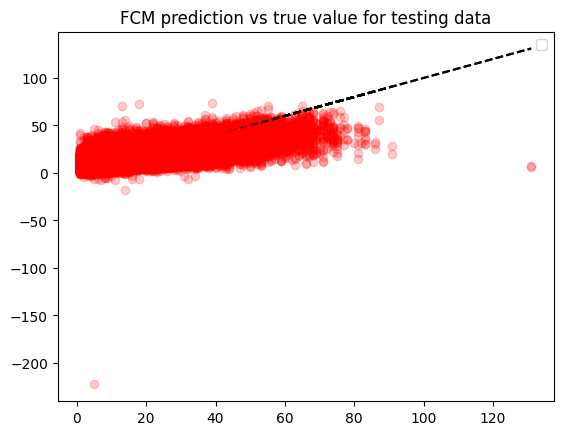

In [74]:
do_experiment(number_of_neighbour_stations, filtered_train, temp_x, temp_y)

Text(0, 0.5, 'Wind speed')

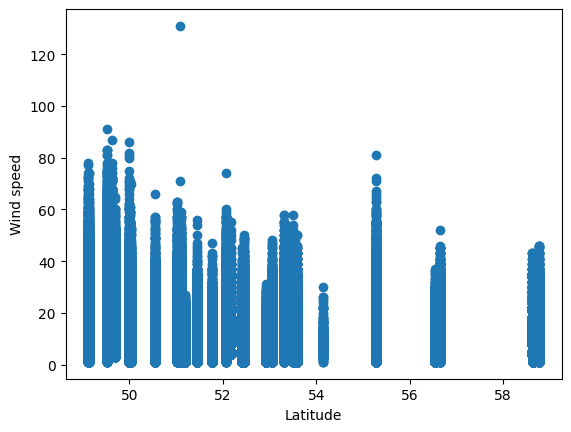

In [102]:
plt.scatter(filtered_train['latitude'], filtered_train['wind_speed'])
plt.xlabel('Latitude')
plt.ylabel('Wind speed')

6.2373±0.096


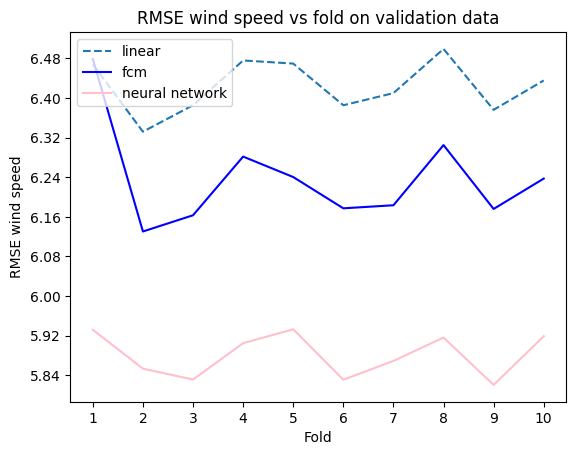

In [124]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
#x_axis = number_of_neighbour_stations
x_axis = [1,2,3,4,5,6,7,8,9,10]
#for exp in training_results:
#     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
#     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
#     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
exp = validation_results[1]
li_train_plot = [d['linear_val'] for d in exp if 'linear_val' in d]
fcm_train_plot = [d['fcm_val'] for d in exp if 'fcm_val' in d]
nn_train_plot = [d['nn_val'] for d in exp if 'nn_val' in d]

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='fcm', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Fold')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs fold on validation data')

print(f"{np.round(np.mean(fcm_train_plot), 4)}±{np.round(np.std(fcm_train_plot),4)}")

6.1024±0.0061


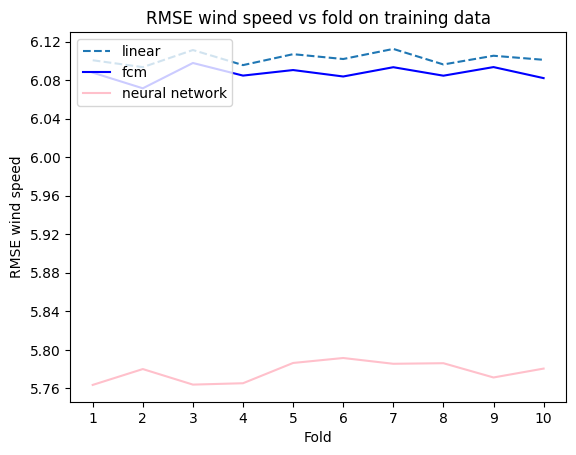

In [119]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
#x_axis = number_of_neighbour_stations
x_axis = [1,2,3,4,5,6,7,8,9,10]
#for exp in training_results:
#     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
#     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
#     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
exp = training_results[0]
li_train_plot = [d['linear_train'] for d in exp if 'linear_train' in d]
fcm_train_plot = [d['fcm_train'] for d in exp if 'fcm_train' in d]
nn_train_plot = [d['nn_train'] for d in exp if 'nn_train' in d]

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='fcm', c='blue')
plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Fold')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs fold on training data')


print(f"{np.round(np.mean(li_train_plot), 4)}±{np.round(np.std(li_train_plot),4)}")